In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os.path as op

In [3]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as coords
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp

Using TensorFlow backend.


In [4]:
fa_file = '/nfs/kitzman2/jacob/proj/jensplice/20220415_wt1_mpsa_trial3/jkp1053_1054_1055.fa'

In [5]:
refseq = pp.get_refseq( fa_file )

In [6]:
bam1 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test*/*out.wbcs.bam

In [7]:
bam2 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT*/*out.wbcs.bam

In [8]:
bam1

['/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM1B/BB_test_Cos1053_JKLab0340_MM1BAligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM2B/BB_test_Cos1053_JKLab0340_MM2BAligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM1B/BB_test_Cos1053_oligodT_MM1BAligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM2B/BB_test_Cos1053_oligodT_MM2BAligned.out.wbcs.bam']

In [9]:
bam2

['/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_243_Cos1053/BB_RT_1_340_243_Cos1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_243_Hek1053/BB_RT_1_340_243_Hek1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_335_Cos1053/BB_RT_1_340_335_Cos1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_335_Hek1053/BB_RT_1_340_335_Hek1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1b_340_243_Hek1053/BB_RT_1b_340_243_Hek1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1b_340_335_Hek1053/BB_RT_1b_340_335_Hek1053Aligned.out.wbcs.bam',
 '/nfs

In [10]:
bam = bam1 + bam2

In [11]:
len( bam )

32

In [12]:
msamp_fn = { b.split( '/')[ -1 ].split( '.' )[ 0 ].replace( 'Aligned', '' ) : b for b in bam }

In [13]:
msamp_fn

{'BB_test_Cos1053_JKLab0340_MM1B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM1B/BB_test_Cos1053_JKLab0340_MM1BAligned.out.wbcs.bam',
 'BB_test_Cos1053_JKLab0340_MM2B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM2B/BB_test_Cos1053_JKLab0340_MM2BAligned.out.wbcs.bam',
 'BB_test_Cos1053_oligodT_MM1B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM1B/BB_test_Cos1053_oligodT_MM1BAligned.out.wbcs.bam',
 'BB_test_Cos1053_oligodT_MM2B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM2B/BB_test_Cos1053_oligodT_MM2BAligned.out.wbcs.bam',
 'BB_RT_1_340_243_Cos1053': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_243_Cos1053/BB_RT_1_340_24

In [14]:
msamp_rnabam = { samp: pysam.AlignmentFile( msamp_fn[ samp ], 'rb' ) for samp in msamp_fn }

In [15]:
%%time
#Ugh stop messing with the min_matches thresholds you are wasting so much time
#keep them here for other exons please and thanks
#you keep losing skips
isos_dfs = { samp: jn.get_all_isoforms_pe( msamp_rnabam[ samp ],
                                           [ ( 649, 696 ), ( 3478, 3533 ) ],
                                            spl_tol = 3,
                                            indel_tol = 20,
                                            min_matches_for = 70,
                                            min_matches_rev = 50 )
             for samp in msamp_rnabam }

CPU times: user 38min 17s, sys: 17.8 s, total: 38min 35s
Wall time: 38min 35s


In [16]:
for samp in isos_dfs.keys():
    
    print( samp )
    
    print( isos_dfs[ samp ].head() )

BB_test_Cos1053_JKLab0340_MM1B
                 read_count
isoform                    
((1267, 1359),)     2400975
((1267, 1350),)     2202889
()                  1143438
bad_ends              75036
bad_starts            29333
BB_test_Cos1053_JKLab0340_MM2B
                 read_count
isoform                    
((1267, 1359),)     5054350
((1267, 1350),)     4607597
()                  2304126
bad_starts            82378
bad_ends              59270
BB_test_Cos1053_oligodT_MM1B
                 read_count
isoform                    
((1267, 1359),)     2190614
((1267, 1350),)     1962858
()                  1061553
bad_ends              65799
bad_starts            26372
BB_test_Cos1053_oligodT_MM2B
                 read_count
isoform                    
((1267, 1359),)     6181724
((1267, 1350),)     5733661
()                  3107707
bad_starts            86387
bad_ends              74857
BB_RT_1_340_243_Cos1053
                 read_count
isoform                    
((1267, 1359),) 

In [17]:
isos_dfs

{'BB_test_Cos1053_JKLab0340_MM1B':                               read_count
 isoform                                 
 ((1267, 1359),)                  2400975
 ((1267, 1350),)                  2202889
 ()                               1143438
 bad_ends                           75036
 bad_starts                         29333
 ...                                  ...
 ((1170, 1225), (1288, 1359))           1
 ((1267, 1316), (2646, 2657))           1
 ((1267, 1352), (1520, 1526))           1
 ((1267, 1350), (2235, 2242))           1
 ((1267, 1350), (1506, 1514))           1
 
 [705 rows x 1 columns],
 'BB_test_Cos1053_JKLab0340_MM2B':                               read_count
 isoform                                 
 ((1267, 1359),)                  5054350
 ((1267, 1350),)                  4607597
 ()                               2304126
 bad_starts                         82378
 bad_ends                           59270
 ...                                  ...
 ((1146, 1220), (1297, 

In [18]:
%%time
isogrp_df = jn.number_and_merge_isoforms( isos_dfs )

BB_test_Cos1053_JKLab0340_MM1B
BB_test_Cos1053_JKLab0340_MM2B
BB_test_Cos1053_oligodT_MM1B
BB_test_Cos1053_oligodT_MM2B
BB_RT_1_340_243_Cos1053
BB_RT_1_340_243_Hek1053
BB_RT_1_340_335_Cos1053
BB_RT_1_340_335_Hek1053
BB_RT_1b_340_243_Hek1053
BB_RT_1b_340_335_Hek1053
BB_RT_1b_ODT_243_Hek1053
BB_RT_1b_ODT_335_Hek1053
BB_RT_1_ODT_243_Cos1053
BB_RT_1_ODT_243_Hek1053
BB_RT_1_ODT_335_Cos1053
BB_RT_1_ODT_335_Hek1053
BB_RT_2_340_243_Cos1054
BB_RT_2_340_243_Hek1054
BB_RT_2_340_335_Cos1054
BB_RT_2_340_335_Hek1054
BB_RT_2_ODT_243_Cos1054
BB_RT_2_ODT_243_Hek1054
BB_RT_2_ODT_335_Cos1054
BB_RT_2_ODT_335_Hek1054
BB_RT_3_340_243_Cos1055
BB_RT_3_340_243_Hek1055
BB_RT_3_340_335_Cos1055
BB_RT_3_340_335_Hek1055
BB_RT_3_ODT_243_Cos1055
BB_RT_3_ODT_243_Hek1055
BB_RT_3_ODT_335_cos1055
BB_RT_3_ODT_335_Hek1055
CPU times: user 19 s, sys: 38 ms, total: 19 s
Wall time: 19 s


In [19]:
isogrp_df.head()

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso0000,"((1136, 1225), (1301, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0001,"((1267, 1339), (2660, 2664))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0002,"((1267, 1290), (1320, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0003,"((1267, 1314), (1337, 1359))",1,273,0,0,1,127,64,59,140,...,0,0,0,0,0,0,0,0,0,0
iso0004,"((1267, 1282), (1328, 1359))",0,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
isogrp_df.loc[ isogrp_df.isoform == ((1267, 1359),) ]

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso2657,"((1267, 1359),)",2400975,5054350,2190614,6181724,1852418,3409650,499731,1003786,3096744,...,148022,670847,935423,2235303,642084,1424797,2636654,1605049,768588,1088778


In [21]:
isogrp_df.loc[ isogrp_df.isoform == ((1267, 1350),) ]

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso1372,"((1267, 1350),)",2202889,4607597,1962858,5733661,1642915,3029467,457547,943894,2728074,...,132018,644707,854764,1928910,607919,1469642,2365654,1373452,730185,1190025


In [22]:
satbls = ! ls /nfs/turbo/umms-kitzmanj/oldvol2/jacob/proj/jensplice/20220426_wt1_subasm_filter_stringent/sapipe/sa/*.haps.final.txt

In [23]:
satbl_fn = { sa.split( '/')[ -1 ].split( '.' )[ 0 ]: pd.read_table( sa ).set_index( 'readgroupid' ) for sa in satbls }

In [24]:
for lib in satbl_fn.keys():
    
    satbl_fn[ lib ] = satbl_fn[ lib ][ [ col for col in satbl_fn[ lib ] if not col.startswith( 'nbp_' ) ] ].copy()

In [25]:
exonbed = pbt.BedTool( '/nfs/kitzman2/smithcat/proj/wt1_2022/refs/wt1_ex9.bed' )

In [26]:
isos = jn.make_junction_graph( exonbed )

In [27]:
isos

{'iso00': ((650, 696), (1267, 1350), (3479, 3533)),
 'iso01': ((650, 696), (1267, 1359), (3479, 3533)),
 'iso02': ((650, 696), (3479, 3533))}

In [28]:
unique_jns = list( { jn for grp,jn_tups in isos.items() for jn_tup in jn_tups for jn in jn_tup
                       if 696 < jn < 3479 } ) 

In [29]:
unique_jns

[1267, 1350, 1359]

In [30]:
for lib in satbl_fn:
    
    print( lib )
    
    print( satbl_fn[ lib ].head() )

JKP1053
                         passes refname                         status  \
readgroupid                                                              
TGAGTTAACTTAAGGACGGTGG     True  jkp815              no_variants_input   
TGAGTGTTTGTTAATTCCCTTGG    True  jkp815              no_variants_input   
TGAGTTGGGTGTTTGATTTGTGG    True  jkp815              no_variants_input   
TGAGTGTTTTTTGGAGCGTTTGG    True  jkp815              no_variants_input   
TGAGTTATGTTCTTCAACTCTGG    True  jkp815  apparently_wt_no_passing_vars   

                         n_variants_passing variant_list  max_altAF  \
readgroupid                                                           
TGAGTTAACTTAAGGACGGTGG                    0          NaN   -1.00000   
TGAGTGTTTGTTAATTCCCTTGG                   0          NaN   -1.00000   
TGAGTTGGGTGTTTGATTTGTGG                   0          NaN   -1.00000   
TGAGTGTTTTTTGGAGCGTTTGG                   0          NaN   -1.00000   
TGAGTTATGTTCTTCAACTCTGG                   0    

In [31]:
isogrp_df

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso0000,"((1136, 1225), (1301, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0001,"((1267, 1339), (2660, 2664))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0002,"((1267, 1290), (1320, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0003,"((1267, 1314), (1337, 1359))",1,273,0,0,1,127,64,59,140,...,0,0,0,0,0,0,0,0,0,0
iso0004,"((1267, 1282), (1328, 1359))",0,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iso7347,"((1161, 1228), (1308, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
iso7348,"((1236, 1242), (1266, 1350))",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
iso7349,"((1146, 1222), (1281, 1359))",0,0,0,0,0,3,0,0,3,...,0,0,0,1,0,0,0,0,2,0


In [32]:
msamp_rnabam = { samp : pysam.AlignmentFile( msamp_fn[ samp ], 'rb' ) for samp in msamp_fn }

In [33]:
%%time
#1 min/sample

iso_df_stats = { lib: jn.summarize_isos_by_var_bc_pe( { samp: bam for samp,bam in msamp_rnabam.items()
                                                        if lib.replace( 'JKP', '' ) in samp },
                                                      [ ( 649, 696 ), ( 3478, 3533 ) ],
                                                      satbl_fn[ lib ],
                                                      isogrp_df[ [ col for col in isogrp_df if lib.replace( 'JKP', '' ) in col or col == 'isoform' ] ],
                                                      unique_jns,
                                                      [ ( ( 1266, 1350 ), ), ( ( 1266, 1359 ), ), () ],
                                                      spl_tol = 3,
                                                      indel_tol = 20,
                                                      min_matches_for = 70,
                                                      min_matches_rev = 50,
                                                      bc_tag = 'BC',
                                                     ) 
                  for lib in satbl_fn }

BB_test_Cos1053_JKLab0340_MM1B
Barcodes processed: 18000
Reads processed: 604886
Barcodes processed: 31000
Reads processed: 1019451
Barcodes processed: 43000
Reads processed: 1411587
Barcodes processed: 65000
Reads processed: 2101358
Barcodes processed: 127000
Reads processed: 4147222
Barcodes processed: 134000
Reads processed: 4362424
Barcodes processed: 148000
Reads processed: 4800167
Barcodes processed: 172000
Reads processed: 5535664
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 78), ('jkp815:1227:C:T', 62), ('jkp815:1228:A:C', 54), ('jkp815:1227:C:G', 52), ('jkp815:1228:A:T', 49)]
For isoform: ((1305, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1236:G:C', 1), ('jkp815:1253:C:G', 1), ('jkp815:1397:T:C', 1), ('jkp815:1304:G:C', 1), ('jkp815:1234:A:C', 1)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 69), ('jkp815:1227:C:T', 52), ('jkp815:1228:A:C', 52), ('jkp

For isoform: ((1270, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1252:T:C', 1), ('jkp815:1267:GTG:GG', 1), ('jkp815:1280:C:G', 1), ('jkp815:1383:T:G', 1), ('jkp815:1299:C:T', 1)]
For isoform: ((1146, 1222), (1294, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1396:T:G', 1), ('jkp815:1335:A:T', 1), ('jkp815:1342:C:G', 1), ('jkp815:1253:C:A', 1)]
For isoform: ((1294, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:C', 1), ('jkp815:1231:G:A', 1), ('jkp815:1365:T:G', 1), ('jkp815:1304:G:T', 1), ('jkp815:1242:G:C', 1)]
For isoform: ((1267, 1298), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:A', 1), ('jkp815:1328:G:A', 1), ('jkp815:1234:A:T', 1)]
For isoform: ((1267, 1345),)
The variants with the top 5 number of barcodes are:
[('jkp815:1281:C:G', 1), ('jkp815:1303:A:T', 1), ('jkp815:1312:G:T', 1), ('jkp815:1343:T:G', 1)]
For isoform: ((1293, 1359),)
The variants with the top 5 

For isoform: ((1267, 1352), (3347, 3353))
The variants with the top 5 number of barcodes are:
[('jkp815:1354:A:G', 1)]
For isoform: ((1267, 1636),)
The variants with the top 5 number of barcodes are:
[('jkp815:1358:A:G', 1)]
For isoform: ((1000, 1069), (1267, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:C', 1), ('jkp815:1324:T:C', 1)]
For isoform: ((1267, 1339), (2727, 2731))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:G', 1)]
For isoform: ((1042, 1046), (1270, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 1)]
For isoform: ((1136, 1141), (1274, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 1)]
For isoform: ((1267, 1282), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1349:A:C', 1)]
For isoform: ((1236, 1241), (1301, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:G:T', 1)]
For isoform: ((1267, 1282), (13

For isoform: ((1267, 1273), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:T:C', 2), ('jkp815:1273:AACCATTCCAGTGTAAAACTTGT:AT', 2), ('jkp815:1304:G:C', 2), ('jkp815:1263:T:C', 1), ('jkp815:1300:G:C', 1)]
For isoform: ((1146, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1378:A:C', 1), ('jkp815:1325:G:C', 1), ('jkp815:1334:C:A', 1), ('jkp815:1300:G:A', 1), ('jkp815:1227:C:A', 1)]
For isoform: ((1267, 1284), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C:G', 1), ('jkp815:1278:T:A', 1), ('jkp815:1228:A:C', 1), ('jkp815:1320:C:T', 1)]
For isoform: ((1267, 1293), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C:G', 1), ('jkp815:1236:G:C', 1), ('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 1), ('jkp815:1315:C:A', 1), ('jkp815:1355:A:C', 1)]
For isoform: ((1236, 1249), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1334:C:T

For isoform: ((1267, 1274), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1273:AACCATTCCAGTGTAAAACTTGT:AT', 1)]
For isoform: ((1136, 1222), (1302, 1317), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1285:G:C', 1), ('jkp815:1398:T:C', 1), ('jkp815:1227:C:T', 1)]
For isoform: ((1146, 1224), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1333:A:C', 1), ('jkp815:1301:A:C', 1), ('jkp815:1287:A:C', 1), ('jkp815:1347:A:T', 1)]
For isoform: ((1267, 1350), (2981, 2985))
The variants with the top 5 number of barcodes are:
[('jkp815:1222:GCCCACAT:GCCACAT', 1), ('jkp815:1375:T:G', 1), ('jkp815:1237:G:A', 1), ('jkp815:1287:A:T', 1), ('jkp815:1228:A:G', 1)]
For isoform: ((1258, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 2), ('jkp815:1342:CTCATACAGGT:CT', 1)]
For isoform: ((1267, 1352), (3348, 3353))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAA

Barcodes processed: 39000
Reads processed: 1122262
Barcodes processed: 70000
Reads processed: 1974376
Barcodes processed: 143000
Reads processed: 4079070
Barcodes processed: 161000
Reads processed: 4588071
Barcodes processed: 173000
Reads processed: 4900343
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 58), ('jkp815:1227:C:A', 54), ('jkp815:1227:C:G', 51), ('jkp815:1228:A:G', 39), ('jkp815:1228:A:C', 36)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 72), ('jkp815:1227:C:A', 68), ('jkp815:1227:C:G', 57), ('jkp815:1228:A:G', 51), ('jkp815:1228:A:T', 40)]
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 77), ('jkp815:1227:C:A', 65), ('jkp815:1227:C:G', 57), ('jkp815:1228:A:G', 51), ('jkp815:1228:A:C', 43)]
For isoform: bad_ends
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 13), ('jkp815:1227:C:A', 10), ('jkp815:

For isoform: ((1267, 1284), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1243:G:T', 1), ('jkp815:1332:C:G', 1), ('jkp815:1281:C:A', 1), ('jkp815:1238:C:A', 1), ('jkp815:1231:G:C', 1)]
For isoform: ((1267, 1297), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 2), ('jkp815:1243:G:T', 1), ('jkp815:1240:G:A', 1), ('jkp815:1360:G:C', 1)]
For isoform: ((1283, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1243:G:T', 1), ('jkp815:1324:T:G', 1), ('jkp815:1305:T:G', 1), ('jkp815:1316:C:G', 1), ('jkp815:1260:C:T', 1)]
For isoform: ((1300, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:CAT:CT', 2), ('jkp815:1343:T:C', 1), ('jkp815:1386:T:C', 1), ('jkp815:1288:A:G', 1), ('jkp815:1256:T:G', 1)]
For isoform: ((1161, 1241), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1349:A:G', 1)]
For isoform: ((1267, 1273), (1295, 1350))
The variants with the top 

For isoform: ((1267, 1293), (1329, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1368:A:C', 1)]
For isoform: ((1267, 1282), (1316, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:C:T', 1), ('jkp815:1305:T:G', 1), ('jkp815:1227:C:T', 1)]
For isoform: ((1267, 1475), (2127, 2133), (3285, 3291))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:CAT:CT', 1)]
For isoform: ((1190, 1225), (1303, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:T', 1)]
For isoform: ((1146, 1222), (1334, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1)]
For isoform: ((1212, 1225), (1288, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1330:C:A', 1), ('jkp815:1363:C:G', 1), ('jkp815:1335:A:C', 1)]
For isoform: ((1267, 1321), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:T', 1)]
For isoform: ((1267, 1358),)
The variants with the top

For isoform: ((1170, 1225), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1391:A:G', 1), ('jkp815:1287:A:G', 1), ('jkp815:1289:A:T', 1), ('jkp815:1319:C:G', 1), ('jkp815:1346:T:C', 1)]
For isoform: ((1000, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1351:G:A', 2), ('jkp815:1390:C:A', 2), ('jkp815:1262:T:A', 2), ('jkp815:1310:C:A', 2), ('jkp815:1237:G:T', 2)]
For isoform: ((1248, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1326:A:C', 1), ('jkp815:1245:T:A', 1), ('jkp815:1237:G:A', 1), ('jkp815:1273:A:G', 1), ('jkp815:1395:T:G', 1)]
For isoform: ((1190, 1243), (1265, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1326:A:C', 1), ('jkp815:1229:T:C', 1), ('jkp815:1302:A:C', 1), ('jkp815:1322:C:A', 1), ('jkp815:1271:G:T', 1)]
For isoform: ((1267, 1317), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 2), ('jkp815:1323:C:T', 1), ('jkp815:1217:ACT:ACCT'

For isoform: ((1273, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1334:C:T', 1), ('jkp815:1228:A:G', 1), ('jkp815:1269:G:A', 1), ('jkp815:1394:A:G', 1), ('jkp815:1237:G:T', 1)]
For isoform: ((1267, 1328), (1354, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 2), ('jkp815:1319:C:A', 2), ('jkp815:1339:G:T', 1), ('jkp815:1237:G:A', 1), ('jkp815:1372:T:A', 1)]
For isoform: ((1267, 1282), (1316, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:G', 2), ('jkp815:1372:T:G', 1), ('jkp815:1287:AAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCA:AA', 1), ('jkp815:1240:G:C', 1), ('jkp815:1260:C:G', 1)]
For isoform: ((1283, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1306:T:A', 1), ('jkp815:1361:T:G', 1), ('jkp815:1227:C:G', 1), ('jkp815:1234:A:G', 1), ('jkp815:1269:G:T', 1)]
For isoform: ((1236, 1246), (1306, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1329:A:T',

For isoform: ((1267, 1309), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1391:A:G', 1), ('jkp815:1359:A:T', 1), ('jkp815:1300:G:A', 1), ('jkp815:1312:G:T', 1)]
For isoform: ((1267, 1280), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1351:G:A', 1), ('jkp815:1282:A:G', 1), ('jkp815:1388:T:A', 1), ('jkp815:1281:C:G', 1), ('jkp815:1237:G:C', 1)]
For isoform: ((1190, 1224), (1307, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1301:A:C', 1), ('jkp815:1299:C:G', 1)]
For isoform: ((1267, 1273), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1390:C:A', 1), ('jkp815:1244:C:G', 1)]
For isoform: ((1293, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1229:T:C', 1), ('jkp815:1363:C:G', 1)]
For isoform: ((1267, 1337), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1285:G:A', 1), ('jkp815:1306:TCT:TT', 1)]
For isoform: ((1256, 1350),)
The

Barcodes processed: 3000
Reads processed: 59421
Barcodes processed: 16000
Reads processed: 316803
Barcodes processed: 30000
Reads processed: 600461
Barcodes processed: 44000
Reads processed: 868077
Barcodes processed: 55000
Reads processed: 1079972
Barcodes processed: 73000
Reads processed: 1425242
Barcodes processed: 92000
Reads processed: 1799416
Barcodes processed: 95000
Reads processed: 1859841
Barcodes processed: 97000
Reads processed: 1901936
Barcodes processed: 108000
Reads processed: 2124692
Barcodes processed: 156000
Reads processed: 3112200
Barcodes processed: 173000
Reads processed: 3451913
Barcodes processed: 176000
Reads processed: 3512335
Barcodes processed: 177000
Reads processed: 3530320
Barcodes processed: 193000
Reads processed: 3860026
Barcodes processed: 207000
Reads processed: 4132945
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 146), ('jkp815:1227:C:A', 140), ('jkp815:1227:C:G', 95), ('jkp815:1228:A:C', 91),

For isoform: ((1267, 1350), (2581, 2591))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:TAC:TGAC', 1)]
For isoform: ((1219, 1239), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1231:G:T', 1)]
For isoform: ((1267, 1289), (1320, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1295:T:C', 1), ('jkp815:1250:C:T', 1), ('jkp815:1245:T:C', 1)]
For isoform: ((1267, 1293), (1328, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:A', 1)]
For isoform: ((1146, 1225), (1307, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1375:T:C', 1)]
For isoform: ((1267, 1308), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1320:C:T', 1)]
For isoform: ((1146, 1224), (1280, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1299:C:G', 1)]
For isoform: ((1190, 1224), (1302, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1257:G:T',

Barcodes processed: 147000
Reads processed: 1569108
Barcodes processed: 150000
Reads processed: 1601204
Barcodes processed: 182000
Reads processed: 1940465
Barcodes processed: 199000
Reads processed: 2114536
Barcodes processed: 206000
Reads processed: 2184247
Barcodes processed: 208000
Reads processed: 2203502
Barcodes processed: 248000
Reads processed: 2608286
Barcodes processed: 257000
Reads processed: 2698084
Barcodes processed: 278000
Reads processed: 2892441
Barcodes processed: 281000
Reads processed: 2922086
Barcodes processed: 297000
Reads processed: 3100616
Barcodes processed: 301000
Reads processed: 3148700
Barcodes processed: 340000
Reads processed: 3595767
Barcodes processed: 349000
Reads processed: 3706706
Barcodes processed: 370000
Reads processed: 3973125
Barcodes processed: 382000
Reads processed: 4121370
Barcodes processed: 391000
Reads processed: 4231149
Barcodes processed: 402000
Reads processed: 4365823
Barcodes processed: 428000
Reads processed: 4648699
Barcodes pro

For isoform: ((1269, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 29), ('jkp815:1228:A:T', 3), ('jkp815:1227:C:G', 3), ('jkp815:1227:C:T', 3), ('jkp815:1271:G:A', 3)]
For isoform: ((1236, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 14), ('jkp815:1265:A:G', 9), ('jkp815:1264:T:G', 7), ('jkp815:1246:A:C', 5), ('jkp815:1227:C:A', 4)]
For isoform: ((1267, 1341), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 2), ('jkp815:1260:C:T', 1), ('jkp815:1278:T:C', 1), ('jkp815:1324:T:C', 1), ('jkp815:1317:G:A', 1)]
For isoform: ((1267, 1282), (1316, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:C:A', 1), ('jkp815:1349:A:T', 1), ('jkp815:1354:A:G', 1), ('jkp815:1281:C:G', 1), ('jkp815:1392:T:A', 1)]
For isoform: ((1236, 1256), (1311, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:T', 1), ('jkp815:1237:G:C', 1), ('jkp815:1253:C:G'

For isoform: ((1236, 1260), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:G', 1)]
For isoform: ((1267, 1314), (1337, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1314:TCCGACCACCTGAAGACCCACACC:TC', 7), ('jkp815:1396:T:A', 1), ('jkp815:1386:T:C', 1), ('jkp815:1279:T:C', 1)]
For isoform: ((1267, 1317),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1), ('jkp815:1360:G:T', 1), ('jkp815:1345:A:C', 1), ('jkp815:1317:GACCACCTGAAGACCCACACCAGGACTCATACA:GA', 1)]
For isoform: ((1236, 1256), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1386:T:C', 1), ('jkp815:1237:G:T', 1)]
For isoform: ((1267, 1316), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1316:CGACCACCTGAAGACCCACACCAGGACTCATACAGGTA:CA', 2), ('jkp815:1229:T:G', 1), ('jkp815:1277:A:C', 1)]
For isoform: ((1267, 1284), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:127

For isoform: ((1351, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1315:C:T', 1), ('jkp815:1240:G:C', 1)]
For isoform: ((1236, 1262), (1303, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:G', 1)]
For isoform: ((2465, 2475),)
The variants with the top 5 number of barcodes are:
[('jkp815:1389:T:A', 1)]
For isoform: ((1267, 1363),)
The variants with the top 5 number of barcodes are:
[('jkp815:1323:C:G', 1), ('jkp815:1363:C:G', 1), ('jkp815:1327:A:T', 1), ('jkp815:1330:CCCACACCAG:CCACCAG', 1)]
For isoform: ((1212, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1308:T:A', 1)]
For isoform: ((1152, 1228), (1314, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:C', 1)]
For isoform: ((1152, 1222), (1302, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1350:G:A', 1)]
For isoform: ((1293, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 1)]

BB_RT_1_340_335_Cos1053
Barcodes processed: 8000
Reads processed: 223123
Barcodes processed: 35000
Reads processed: 1009518
Barcodes processed: 47000
Reads processed: 1360255
Barcodes processed: 73000
Reads processed: 2112975
Barcodes processed: 121000
Reads processed: 3569518
Barcodes processed: 152000
Reads processed: 4478212
Barcodes processed: 159000
Reads processed: 4688956
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 56), ('jkp815:1227:C:T', 47), ('jkp815:1227:C:G', 39), ('jkp815:1228:A:C', 38), ('jkp815:1228:A:T', 30)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 54), ('jkp815:1227:C:A', 50), ('jkp815:1227:C:G', 40), ('jkp815:1228:A:C', 35), ('jkp815:1228:A:T', 34)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 55), ('jkp815:1227:C:T', 48), ('jkp815:1227:C:G', 44), ('jkp815:1228:A:C', 36), ('jkp815:1228:A:T', 35)]
For isofor

Barcodes processed: 8000
Reads processed: 89270
Barcodes processed: 37000
Reads processed: 429071
Barcodes processed: 73000
Reads processed: 897802
Barcodes processed: 74000
Reads processed: 911157
Barcodes processed: 80000
Reads processed: 980985
Barcodes processed: 83000
Reads processed: 1009587
Barcodes processed: 97000
Reads processed: 1160430
Barcodes processed: 101000
Reads processed: 1204178
Barcodes processed: 112000
Reads processed: 1316934
Barcodes processed: 133000
Reads processed: 1576665
Barcodes processed: 154000
Reads processed: 1807344
Barcodes processed: 160000
Reads processed: 1868689
Barcodes processed: 161000
Reads processed: 1877565
Barcodes processed: 171000
Reads processed: 1979851
Barcodes processed: 192000
Reads processed: 2218923
Barcodes processed: 200000
Reads processed: 2295253
Barcodes processed: 205000
Reads processed: 2344684
Barcodes processed: 206000
Reads processed: 2354404
Barcodes processed: 215000
Reads processed: 2442662
Barcodes processed: 252000

For isoform: ((1267, 1321), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 1)]
For isoform: ((1267, 1312), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1331:C:G', 1)]
For isoform: ((1190, 1221), (1298, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1355:A:T', 1)]
For isoform: ((1267, 1312), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:GGTCCGACCACCTGAAGACCCACACCAGGACTCATACA:GA', 2)]
For isoform: ((1267, 1336), (2978, 2985))
The variants with the top 5 number of barcodes are:
[('jkp815:1326:A:C', 1), ('jkp815:1327:A:T', 1)]
For isoform: ((1237, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1384:A:G', 1)]
For isoform: ((1267, 1309), (1344, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1309:CCCGGTCCGACCACCTGAAGACCCACACCAGGACTC:CC', 1)]
For isoform: ((1267, 1341),)
The variants with the top 5 number of barcodes are:
[

Barcodes processed: 17000
Reads processed: 138171
Barcodes processed: 19000
Reads processed: 154471
Barcodes processed: 27000
Reads processed: 222658
Barcodes processed: 50000
Reads processed: 401574
Barcodes processed: 57000
Reads processed: 459563
Barcodes processed: 77000
Reads processed: 641721
Barcodes processed: 110000
Reads processed: 922558
Barcodes processed: 153000
Reads processed: 1253862
Barcodes processed: 157000
Reads processed: 1283456
Barcodes processed: 163000
Reads processed: 1332135
Barcodes processed: 175000
Reads processed: 1423443
Barcodes processed: 194000
Reads processed: 1588810
Barcodes processed: 214000
Reads processed: 1746867
Barcodes processed: 242000
Reads processed: 1965094
Barcodes processed: 266000
Reads processed: 2146003
Barcodes processed: 303000
Reads processed: 2438430
Barcodes processed: 312000
Reads processed: 2504040
Barcodes processed: 356000
Reads processed: 2872068
Barcodes processed: 393000
Reads processed: 3193138
Barcodes processed: 40400

For isoform: soft_clipped
The variants with the top 5 number of barcodes are:
[('jkp815:1324:T:G', 3), ('jkp815:1283:G:T', 2), ('jkp815:1312:G:T', 2), ('jkp815:1270:T:C', 2), ('jkp815:1280:C:T', 2)]
For isoform: ((1267, 1330), (1653, 1664))
The variants with the top 5 number of barcodes are:
[('jkp815:1251:T:G', 2), ('jkp815:1319:C:T', 1), ('jkp815:1295:T:G', 1), ('jkp815:1337:C:T', 1)]
For isoform: ((1267, 1322), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGT:CT', 3), ('jkp815:1290:A:T', 1), ('jkp815:1354:A:T', 1), ('jkp815:1308:T:G', 1), ('jkp815:1228:A:G', 1)]
For isoform: ((1285, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1253:C:G', 1), ('jkp815:1266:G:T', 1), ('jkp815:1235:G:T', 1), ('jkp815:1279:T:C', 1), ('jkp815:1285:GTA:GA', 1)]
For isoform: ((1267, 1278), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:G:A', 1), ('jkp815:1288:A:T', 1), ('jkp815:1259:C:

For isoform: ((1267, 1303), (1340, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 3), ('jkp815:1316:C:A', 1), ('jkp815:1248:A:T', 1), ('jkp815:1252:T:A', 1), ('jkp815:1385:T:A', 1)]
For isoform: ((1146, 1220), (1292, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1302:A:T', 1)]
For isoform: ((1136, 1222), (1291, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1224:CCAC:CC', 1)]
For isoform: ((1267, 1328), (1588, 1593), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1232:T:G', 1)]
For isoform: ((1236, 1260), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1329:A:T', 1)]
For isoform: ((1236, 1243), (1265, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1365:T:C', 1), ('jkp815:1391:A:T', 1)]
For isoform: ((1267, 1337), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C

For isoform: ((1267, 1319), (1341, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:G', 1), ('jkp815:1283:G:T', 1)]
For isoform: ((1267, 1302), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1242:G:C', 1), ('jkp815:1319:C:A', 1), ('jkp815:1308:T:C', 1)]
For isoform: ((1136, 1224), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1272:A:C', 1)]
For isoform: ((1212, 1236), (1312, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:C', 1)]
For isoform: ((1267, 1318), (2166, 2171))
The variants with the top 5 number of barcodes are:
[('jkp815:1361:T:A', 1)]
For isoform: ((1340, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1339:G:T', 1), ('jkp815:1303:A:G', 1)]
For isoform: ((1267, 1295), (1337, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1295:TCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:TC', 3), ('jkp815:1227:C:G', 1)]
For isoform: ((12

Barcodes processed: 10000
Reads processed: 112195
Barcodes processed: 18000
Reads processed: 201658
Barcodes processed: 20000
Reads processed: 224694
Barcodes processed: 23000
Reads processed: 254127
Barcodes processed: 29000
Reads processed: 319418
Barcodes processed: 66000
Reads processed: 783747
Barcodes processed: 95000
Reads processed: 1087563
Barcodes processed: 130000
Reads processed: 1478718
Barcodes processed: 133000
Reads processed: 1514462
Barcodes processed: 166000
Reads processed: 1846351
Barcodes processed: 169000
Reads processed: 1880770
Barcodes processed: 210000
Reads processed: 2315565
Barcodes processed: 228000
Reads processed: 2548834
Barcodes processed: 241000
Reads processed: 2714337
Barcodes processed: 252000
Reads processed: 2868092
Barcodes processed: 259000
Reads processed: 2973638
Barcodes processed: 265000
Reads processed: 3059556
Barcodes processed: 305000
Reads processed: 3594785
Barcodes processed: 335000
Reads processed: 3931933
Barcodes processed: 37000

For isoform: ((1236, 1268), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1264:T:G', 1)]
For isoform: ((1286, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:A', 1)]
For isoform: ((1267, 1303), (1332, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 2)]
For isoform: ((1267, 1319), (1341, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:G', 1)]
For isoform: ((1267, 1284), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1358:A:T', 1), ('jkp815:1227:C:A', 1), ('jkp815:1314:T:G', 1)]
For isoform: ((1267, 1283), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1261:A:T', 1), ('jkp815:1386:T:G', 1)]
For isoform: ((1267, 1287), (1338, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1287:AAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCA:AA', 3)]
For isoform: ((126

Barcodes processed: 112000
Reads processed: 998759
Barcodes processed: 120000
Reads processed: 1063713
Barcodes processed: 126000
Reads processed: 1110959
Barcodes processed: 140000
Reads processed: 1225318
Barcodes processed: 154000
Reads processed: 1352746
Barcodes processed: 171000
Reads processed: 1496844
Barcodes processed: 176000
Reads processed: 1542073
Barcodes processed: 194000
Reads processed: 1688596
Barcodes processed: 199000
Reads processed: 1726515
Barcodes processed: 230000
Reads processed: 1988629
Barcodes processed: 265000
Reads processed: 2262284
Barcodes processed: 282000
Reads processed: 2422874
Barcodes processed: 297000
Reads processed: 2567624
Barcodes processed: 335000
Reads processed: 2934686
Barcodes processed: 337000
Reads processed: 2957415
Barcodes processed: 355000
Reads processed: 3140601
Barcodes processed: 373000
Reads processed: 3323171
Barcodes processed: 385000
Reads processed: 3441266
Barcodes processed: 407000
Reads processed: 3628413
Barcodes proc

For isoform: ((1267, 1294), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1294:GTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 7), ('jkp815:1335:A:G', 1), ('jkp815:1287:A:G', 1), ('jkp815:1256:T:C', 1), ('jkp815:1227:C:G', 1)]
For isoform: ((1267, 1294), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1294:GTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 7), ('jkp815:1292:T:A', 1), ('jkp815:1284:T:G', 1), ('jkp815:1308:T:C', 1), ('jkp815:1227:C:T', 1)]
For isoform: ((1300, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1239:C:A', 1), ('jkp815:1353:A:G', 1), ('jkp815:1299:C:G', 1), ('jkp815:1244:C:T', 1), ('jkp815:1338:A:T', 1)]
For isoform: ((1267, 1322), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGT:CT', 3), ('jkp815:1374:C:A', 1), ('jkp815:1287:A:T', 1), ('jkp815:1250:C:G', 1), ('jkp815:1335:A:T', 1)]
For isoform: ((1267, 1283), (3375, 338

For isoform: ((1236, 1259), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:G', 1)]
For isoform: ((1236, 1250), (1303, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1398:T:A', 1)]
For isoform: ((1236, 1256), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1273:A:T', 1), ('jkp815:1227:C:G', 1), ('jkp815:1335:A:T', 1)]
For isoform: ((1161, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1286:T:G', 1)]
For isoform: ((1267, 1283), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:AGA:AA', 1), ('jkp815:1240:GAG:GG', 1), ('jkp815:1234:A:G', 1), ('jkp815:1228:A:G', 1), ('jkp815:1351:G:A', 1)]
For isoform: ((1267, 1322), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1259:C:T', 1), ('jkp815:1247:G:T', 1), ('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGTA:CA', 1), ('jkp815:1311:C:T', 1)]
For isoform: ((1267, 1303), (1340, 1350))
The

For isoform: ((1267, 1285), (1333, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1285:GTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCA:GA', 1)]
For isoform: ((1267, 1321), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGTA:CA', 1)]
For isoform: ((1267, 1314), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1351:G:A', 1)]
For isoform: ((1267, 1284), (1328, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:G:A', 1), ('jkp815:1372:T:C', 1)]
For isoform: ((1161, 1225), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1255:C:T', 1)]
For isoform: ((1170, 1225), (1269, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1225:CACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGTG:CG', 1)]
For isoform: ((1230, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:T', 1)]
For isoform: ((1190, 1220), (1

For isoform: ((1267, 1314), (1337, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1314:TCCGACCACCTGAAGACCCACACC:TC', 2)]
For isoform: ((1267, 1314), (1337, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1314:TCCGACCACCTGAAGACCCACACC:TC', 3)]
For isoform: ((1267, 1316), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1316:CGACCACCTGAAGACCCACACCAGGACTCATACAGGTA:CA', 2), ('jkp815:1316:C:A', 1)]
For isoform: ((1267, 1313), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1279:T:C', 1), ('jkp815:1315:C:T', 1), ('jkp815:1362:G:T', 1)]
For isoform: ((1281, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1242:G:C', 1), ('jkp815:1243:G:C', 1), ('jkp815:1330:C:T', 1), ('jkp815:1341:A:T', 1), ('jkp815:1348:C:G', 1)]
For isoform: ((1299, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1259:C:G', 1), ('jkp815:1368:A:C', 1), ('jkp815:1340:G:C', 1), ('jkp815:1

For isoform: ((1267, 1284), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1305:T:C', 1)]
For isoform: ((1267, 1346), (2585, 2591))
The variants with the top 5 number of barcodes are:
[('jkp815:1359:A:T', 1)]
For isoform: ((1267, 1341), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:C:A', 1)]
For isoform: ((1267, 1319), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1347:A:G', 1)]
For isoform: ((1136, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:A', 1)]
For isoform: ((1338, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1372:T:C', 1)]
For isoform: ((1236, 1261), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1363:C:A', 1)]
478886 total barcodes in bam file
3451202 total reads in the bam file
443925 (92.70%) barcodes had no variant in the subassembly
3292857 (95.41%) reads were associated with barcodes without var

For isoform: ((1267, 1285), (1333, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1392:T:G', 1), ('jkp815:1350:G:A', 1), ('jkp815:1385:T:C', 1), ('jkp815:1277:A:G', 1), ('jkp815:1222:GCCCACAT:GCCACAT', 1)]
For isoform: ((1267, 1340), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1342:CTC:CC', 2), ('jkp815:1311:C:T', 1), ('jkp815:1248:A:C', 1), ('jkp815:1241:A:T', 1), ('jkp815:1324:T:C', 1)]
For isoform: ((1236, 1255), (1306, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:A', 1), ('jkp815:1342:C:T', 1), ('jkp815:1242:G:T', 1)]
For isoform: ((1277, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1397:T:G', 1), ('jkp815:1335:A:C', 1), ('jkp815:1367:A:C', 1), ('jkp815:1335:A:T', 1), ('jkp815:1313:G:C', 1)]
For isoform: ((1236, 1241), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1334:C:A', 1)]
For isoform: ((1267, 1327), (1351, 1359))
The variants with the to

For isoform: ((1190, 1232), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1238:C:G', 1)]
For isoform: ((1303, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1)]
For isoform: ((1136, 1225), (1289, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1310:C:A', 1)]
For isoform: ((1255, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1)]
For isoform: ((1267, 1357),)
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:C', 1)]
For isoform: ((1267, 1337),)
The variants with the top 5 number of barcodes are:
[('jkp815:1398:T:G', 1)]
For isoform: ((1152, 1225), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1), ('jkp815:1323:C:T', 1)]
For isoform: ((1267, 1305), (1337, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACATTGTTAGGGCCGAGGCT:AT', 1)]
For isoform: ((1146, 1223), (1309, 1350))
The variants w

Barcodes processed: 653000
Reads processed: 7375735
Barcodes processed: 655000
Reads processed: 7395122
Barcodes processed: 656000
Reads processed: 7406534
Barcodes processed: 657000
Reads processed: 7416488
Barcodes processed: 665000
Reads processed: 7502330
Barcodes processed: 673000
Reads processed: 7585793
Barcodes processed: 690000
Reads processed: 7762526
Barcodes processed: 695000
Reads processed: 7810785
Barcodes processed: 706000
Reads processed: 7917398
Barcodes processed: 720000
Reads processed: 8073310
Barcodes processed: 726000
Reads processed: 8140844
Barcodes processed: 736000
Reads processed: 8248777
Barcodes processed: 743000
Reads processed: 8320813
Barcodes processed: 748000
Reads processed: 8368153
Barcodes processed: 770000
Reads processed: 8590485
Barcodes processed: 772000
Reads processed: 8607714
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 753), ('jkp815:1227:C:T', 722), ('jkp815:1227:C:G', 601), ('jkp815

For isoform: ((1267, 1322), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGT:CT', 4), ('jkp815:1373:T:A', 1), ('jkp815:1346:TACAGGTAAAACA:TA', 1), ('jkp815:1392:T:A', 1), ('jkp815:1231:G:T', 1)]
For isoform: ((1267, 1321),)
The variants with the top 5 number of barcodes are:
[('jkp815:1320:CACCTGAAGACCCACACCAGGACTCATACAGGTAAAACAA:CA', 1)]
For isoform: ((1267, 1278), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1334:C:A', 1)]
For isoform: ((2928, 2932),)
The variants with the top 5 number of barcodes are:
[('jkp815:1296:CAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTC:CC', 1)]
For isoform: ((1267, 1327), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:C:T', 1), ('jkp815:1327:A:T', 1), ('jkp815:1234:A:G', 1), ('jkp815:1304:GTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1265:A:C', 1)]
For isoform: ((1190, 1226), (1317, 1359))
The variants with the top 5 numb

For isoform: ((1267, 1352), (1520, 1527))
The variants with the top 5 number of barcodes are:
[('jkp815:1238:C:T', 1)]
For isoform: ((1190, 1225), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1331:C:G', 1)]
For isoform: ((1267, 1279), (1318, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1), ('jkp815:1382:T:C', 1), ('jkp815:1287:A:T', 1), ('jkp815:1358:A:C', 1), ('jkp815:1309:C:T', 1)]
For isoform: ((1267, 1297), (1340, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1284:T:G', 1)]
For isoform: ((885, 890), (1276, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:ACCAT:ACAT', 1)]
For isoform: ((1267, 1309), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1271:G:C', 1), ('jkp815:1247:G:T', 1)]
For isoform: ((1283, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1329:A:T', 1), ('jkp815:1316:C:T', 1), ('jkp815:1374:C:A', 1), ('jkp81

For isoform: ((1260, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:G', 1), ('jkp815:1231:G:T', 1)]
For isoform: ((1146, 1224), (1296, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:T', 1)]
For isoform: ((1200, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1295:T:A', 1)]
For isoform: ((1267, 1337), (2644, 2657), (2790, 2795))
The variants with the top 5 number of barcodes are:
[('jkp815:1355:AACA:AA', 1)]
For isoform: ((1136, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1306:T:C', 1)]
For isoform: ((1267, 1330), (2484, 2489), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:CCAGGACTCATACAGGTA:CA', 1)]
For isoform: ((1267, 1284), (1324, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1398:T:G', 1)]
For isoform: ((1146, 1222), (1288, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:G:A', 1)]
For isoform: 

Barcodes processed: 16000
Reads processed: 247438
Barcodes processed: 76000
Reads processed: 1198014
Barcodes processed: 86000
Reads processed: 1358652
Barcodes processed: 90000
Reads processed: 1412662
Barcodes processed: 97000
Reads processed: 1503294
Barcodes processed: 116000
Reads processed: 1760345
Barcodes processed: 119000
Reads processed: 1800428
Barcodes processed: 124000
Reads processed: 1863344
Barcodes processed: 145000
Reads processed: 2207464
Barcodes processed: 167000
Reads processed: 2526373
Barcodes processed: 194000
Reads processed: 2877312
Barcodes processed: 224000
Reads processed: 3294927
Barcodes processed: 236000
Reads processed: 3439810
Barcodes processed: 261000
Reads processed: 3876299
Barcodes processed: 266000
Reads processed: 3963193
Barcodes processed: 302000
Reads processed: 4597754
Barcodes processed: 313000
Reads processed: 4817368
Barcodes processed: 327000
Reads processed: 5089683
Barcodes processed: 343000
Reads processed: 5381785
Barcodes processed

For isoform: ((1267, 1322), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGT:CT', 3), ('jkp815:1227:C:T', 1)]
For isoform: ((1300, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1253:C:G', 1), ('jkp815:1298:G:A', 1), ('jkp815:1231:G:C', 1), ('jkp815:1293:TGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 1), ('jkp815:1279:T:G', 1)]
For isoform: ((1267, 1337), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:C', 1), ('jkp815:1337:CAGGACTCATACAGGTA:CA', 1), ('jkp815:1227:CATTG:CT', 1)]
For isoform: ((1190, 1222), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1378:A:C', 1)]
For isoform: ((1267, 1312), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:GGTCCGACCACCTGAAGACCCACACCAGGACTCATACA:GA', 3), ('jkp815:1315:C:G', 1)]
For isoform: ((1268, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:12

For isoform: ((1281, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1283:G:T', 1), ('jkp815:1251:T:G', 1), ('jkp815:1289:A:C', 1), ('jkp815:1228:A:C', 1), ('jkp815:1262:T:A', 1)]
For isoform: ((1267, 1352), (2228, 2234))
The variants with the top 5 number of barcodes are:
[('jkp815:1233:T:C', 1)]
For isoform: ((1267, 1305), (1332, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1305:TTCTCCCGGTCCGACCACCTGAAGACCC:TC', 4), ('jkp815:1323:C:G', 1)]
For isoform: ((1267, 1359), (2767, 2775))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:G', 1)]
For isoform: ((1236, 1243), (1265, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1243:GCTAGACCTTCTCTGTCCATTTA:GA', 2)]
For isoform: ((1267, 1304), (1336, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:GTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC', 2), ('jkp815:1291:CTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGA:CA', 1)]
For isoform: ((1267,

BB_RT_2_340_243_Cos1054
Barcodes processed: 24000
Reads processed: 752546
Barcodes processed: 33000
Reads processed: 1029479
Barcodes processed: 88000
Reads processed: 2765850
Barcodes processed: 90000
Reads processed: 2823767
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 39), ('jkp815:1227:C:A', 32), ('jkp815:1228:A:T', 31), ('jkp815:1228:A:C', 25), ('jkp815:1227:C:T', 24)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 33), ('jkp815:1228:A:T', 32), ('jkp815:1227:C:T', 27), ('jkp815:1227:C:A', 24), ('jkp815:1228:A:C', 19)]
For isoform: ((1284, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1285:G:T', 2), ('jkp815:1233:T:G', 2), ('jkp815:1351:G:C', 2), ('jkp815:1351:G:A', 2), ('jkp815:1237:G:A', 2)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 20), ('jkp815:1227:C:T', 19), ('jkp815:1227:C:G', 17), ('jkp815:1227

For isoform: ((1267, 1342), (3345, 3353))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:TACAGGTAAA:TA', 1)]
For isoform: ((1190, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1331:C:T', 1)]
For isoform: ((1267, 1339), (1340, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1389:T:A', 1)]
For isoform: ((1267, 1325), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1253:C:A', 1)]
For isoform: ((1190, 1226), (1292, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1253:C:A', 1)]
For isoform: ((1236, 1241), (1276, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1252:T:C', 1)]
For isoform: ((1267, 1333),)
The variants with the top 5 number of barcodes are:
[('jkp815:1393:T:G', 1)]
For isoform: ((1267, 1358),)
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:T', 1)]
For isoform: ((1287, 1359),)
The variants with the top 5 number of barcodes a

For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A', 6), ('jkp815:1265:AGGTGTGA:AGTGTGA', 5), ('jkp815:1312:G:T', 3), ('jkp815:1323:C:G', 2), ('jkp815:1225:CAC:CC', 1)]
For isoform: ((1236, 1257), (1293, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1319:C:A', 1), ('jkp815:1317:G:A', 1)]
For isoform: ((1268, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A', 3), ('jkp815:1366:A:G', 2), ('jkp815:1222:GCCCACAT:GCCACAT', 2), ('jkp815:1368:A:T', 2), ('jkp815:1282:A:G', 1)]
For isoform: ((1267, 1287), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1), ('jkp815:1380:A:G', 1)]
For isoform: ((1267, 1274), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:T', 1), ('jkp815:1372:T:G', 1), ('jkp815:1290:ACT:AT', 1)]
For isoform: ((1267, 1305), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1305:TT

For isoform: ((1267, 1326),)
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:G', 1)]
For isoform: ((1267, 1346), (3346, 3353))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:TACAGGT:TC', 1)]
For isoform: ((1351, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1286:TAAAACT:TAAACT', 1)]
For isoform: ((1267, 1301), (1333, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1301:AAAGTTCTCCCGGTCCGACCACCTGAAGACCCA:AA', 5), ('jkp815:1327:A:T', 1), ('jkp815:1340:G:A', 1), ('jkp815:1231:G:T', 1)]
For isoform: ((1267, 1301), (1333, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1301:AAAGTTCTCCCGGTCCGACCACCTGAAGACCCA:AA', 5), ('jkp815:1354:A:T', 1), ('jkp815:1315:C:G', 1), ('jkp815:1282:A:G', 1)]
For isoform: ((1146, 1226), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1236:G:C', 1)]
For isoform: ((1190, 1224), (1279, 1350))
The variants with the top 5 number of barc

For isoform: ((1236, 1252), (1281, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1)]
For isoform: ((1267, 1351), (2228, 2234))
The variants with the top 5 number of barcodes are:
[('jkp815:1223:C:T', 1), ('jkp815:1377:C:T', 1), ('jkp815:1326:A:G', 1)]
For isoform: ((1267, 2761),)
The variants with the top 5 number of barcodes are:
[('jkp815:1353:A:G', 1)]
For isoform: ((1236, 1262), (1316, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1252:T:C', 1), ('jkp815:1369:C:T', 1)]
For isoform: ((1236, 1256), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:G:A', 1)]
For isoform: ((1267, 1273), (1317, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:G', 1), ('jkp815:1283:G:A', 1), ('jkp815:1290:ACT:AT', 1), ('jkp815:1250:C:G', 1), ('jkp815:1307:C:G', 1)]
For isoform: ((1267, 1291), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1299:C:A', 1)]
For isofo

Barcodes processed: 27000
Reads processed: 936537
Barcodes processed: 38000
Reads processed: 1300629
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 7), ('jkp815:1283:G:T', 7), ('jkp815:1317:G:T', 6), ('jkp815:1287:A:C', 5), ('jkp815:1268:T:A', 5)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 9), ('jkp815:1228:A:T', 8), ('jkp815:1227:C:A', 6), ('jkp815:1227:C:T', 6), ('jkp815:1228:A:C', 5)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:G', 7), ('jkp815:1227:C:G', 7), ('jkp815:1265:A:G', 6), ('jkp815:1227:C:T', 6), ('jkp815:1228:A:C', 5)]
For isoform: soft_clipped
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:A', 2), ('jkp815:1349:A:G', 1), ('jkp815:1353:A:T', 1), ('jkp815:1298:G:C', 1), ('jkp815:1239:C:A', 1)]
For isoform: ((1284, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A', 3), (

For isoform: ((1267, 1290), (1329, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1), ('jkp815:1256:T:A', 1)]
For isoform: ((1267, 1334), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:G', 1), ('jkp815:1219:T:C', 1), ('jkp815:1398:T:C', 1)]
For isoform: ((1273, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1264:T:A', 1)]
For isoform: ((1267, 1301), (1333, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1301:AAAGTTCTCCCGGTCCGACCACCTGAAGACCCA:AA', 2), ('jkp815:1385:T:C', 1)]
For isoform: ((1273, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 1), ('jkp815:1296:C:T', 1)]
For isoform: ((1285, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1272:A:G', 1), ('jkp815:1283:GTG:GG', 1)]
For isoform: ((1267, 1314), (1348, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1276:CAT:CAAT', 1)]
For isoform: ((1294, 

Barcodes processed: 14000
Reads processed: 455553
Barcodes processed: 47000
Reads processed: 1446744
Barcodes processed: 104000
Reads processed: 3255931
Barcodes processed: 108000
Reads processed: 3374941
Barcodes processed: 127000
Reads processed: 3949125
Barcodes processed: 139000
Reads processed: 4267644
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 33), ('jkp815:1228:A:T', 31), ('jkp815:1227:C:G', 30), ('jkp815:1227:C:A', 22), ('jkp815:1228:A:C', 20)]
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 33), ('jkp815:1227:C:T', 32), ('jkp815:1228:A:T', 32), ('jkp815:1227:C:A', 24), ('jkp815:1228:A:C', 21)]
For isoform: ((1284, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 2), ('jkp815:1295:T:C', 2), ('jkp815:1336:C:T', 2), ('jkp815:1247:G:C', 1), ('jkp815:1363:C:T', 1)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp8

For isoform: ((1294, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1378:A:C', 1), ('jkp815:1260:C:T', 1)]
For isoform: ((1267, 1321), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1391:ATTATTTTT:ATTTATTTTT', 1), ('jkp815:1297:A:G', 1), ('jkp815:1374:C:G', 1), ('jkp815:1283:G:A', 1), ('jkp815:1228:A:T', 1)]
For isoform: ((1258, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1319:C:G', 1)]
For isoform: ((1267, 1323), (2704, 2710))
The variants with the top 5 number of barcodes are:
[('jkp815:1324:TGAAGACCCACACCAGGACTCATACAGGTAAA:TA', 2)]
For isoform: ((1267, 1330), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1331:CCACACCAGGACTCATACAGGTAA:CA', 1)]
For isoform: ((1267, 1318), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1261:A:G', 1)]
For isoform: ((1267, 1305), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1), 

Barcodes processed: 4000
Reads processed: 52568
Barcodes processed: 5000
Reads processed: 65024
Barcodes processed: 14000
Reads processed: 187672
Barcodes processed: 37000
Reads processed: 500842
Barcodes processed: 43000
Reads processed: 594656
Barcodes processed: 56000
Reads processed: 777366
Barcodes processed: 78000
Reads processed: 1063332
Barcodes processed: 80000
Reads processed: 1088446
Barcodes processed: 90000
Reads processed: 1211164
Barcodes processed: 110000
Reads processed: 1472921
Barcodes processed: 116000
Reads processed: 1552949
Barcodes processed: 138000
Reads processed: 1829642
Barcodes processed: 148000
Reads processed: 1950355
Barcodes processed: 160000
Reads processed: 2110084
Barcodes processed: 172000
Reads processed: 2255851
Barcodes processed: 179000
Reads processed: 2337198
Barcodes processed: 186000
Reads processed: 2425465
Barcodes processed: 193000
Reads processed: 2529602
Barcodes processed: 211000
Reads processed: 2786249
Barcodes processed: 216000
Read

For isoform: ((1267, 1312), (1329, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1395:T:A', 1), ('jkp815:1364:G:C', 1), ('jkp815:1332:C:T', 1), ('jkp815:1380:A:G', 1), ('jkp815:1296:C:A', 1)]
For isoform: ((1236, 1268), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1361:T:A', 1), ('jkp815:1348:C:A', 1)]
For isoform: ((1340, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1292:T:A', 1), ('jkp815:1265:A:C', 1)]
For isoform: ((1267, 1279), (1322, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1362:G:A', 2), ('jkp815:1238:C:A', 1), ('jkp815:1279:T:A', 1), ('jkp815:1346:T:A', 1), ('jkp815:1379:C:A', 1)]
For isoform: ((1267, 2223),)
The variants with the top 5 number of barcodes are:
[('jkp815:1259:C:G', 1), ('jkp815:1350:G:A', 1), ('jkp815:1228:A:C', 1), ('jkp815:1303:A:G', 1), ('jkp815:1309:C:T', 1)]
For isoform: ((1267, 1307), (1341, 1359))
The variants with the top 5 number of barcodes are:
[

For isoform: ((1267, 1273), (1297, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:C', 1), ('jkp815:1334:C:A', 1), ('jkp815:1296:C:T', 1), ('jkp815:1396:T:A', 1), ('jkp815:1228:A:G', 1)]
For isoform: ((1221, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1334:C:G', 1)]
For isoform: ((1267, 1356),)
The variants with the top 5 number of barcodes are:
[('jkp815:1393:T:G', 1), ('jkp815:1298:G:T', 1), ('jkp815:1354:AAACAAG:AAAG', 1), ('jkp815:1322:C:A', 1), ('jkp815:1281:C:G', 1)]
For isoform: ((1267, 1337), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 1), ('jkp815:1266:G:T', 1), ('jkp815:1355:A:C', 1), ('jkp815:1332:C:A', 1)]
For isoform: ((1000, 1069), (1267, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1256:T:C', 1)]
For isoform: ((1267, 1302), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1)]
For

For isoform: ((1267, 1282), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:T', 1)]
For isoform: ((1337, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:G:A', 1)]
For isoform: ((1273, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1395:T:C', 1), ('jkp815:1254:T:A', 1), ('jkp815:1329:A:T', 1), ('jkp815:1166:G:A', 1)]
For isoform: ((1267, 1323), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1282:A:C', 1)]
For isoform: ((1267, 1347), (3237, 3242))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:ATACAGGT:AT', 1)]
For isoform: ((1267, 1339), (2585, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1312:G:A', 1)]
For isoform: ((1267, 1284), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C:A', 1), ('jkp815:1330:C:T', 1), ('jkp815:1250:C:A', 1), ('jkp815:1293:T:G', 1)]
For isoform: ((1267, 1306), (1338, 1359))

Barcodes processed: 13000
Reads processed: 425224
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 10), ('jkp815:1334:C:T', 6), ('jkp815:1227:C:A', 6), ('jkp815:1324:T:G', 6), ('jkp815:1253:C:A', 5)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 7), ('jkp815:1227:C:A', 6), ('jkp815:1337:C:A', 5), ('jkp815:1265:A:T', 5), ('jkp815:1231:G:T', 5)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 9), ('jkp815:1262:T:G', 6), ('jkp815:1228:A:C', 6), ('jkp815:1265:A:G', 6), ('jkp815:1265:A:T', 6)]
For isoform: bad_ends
The variants with the top 5 number of barcodes are:
[('jkp815:1305:T:C', 1), ('jkp815:1396:T:A', 1), ('jkp815:1346:TACAGGTAAA:TA', 1), ('jkp815:1372:T:A', 1), ('jkp815:1257:G:T', 1)]
For isoform: ((1267, 1313), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:GTCCGACCACCTGAAGACCCACACCAGGACTCATA:GA', 1

For isoform: ((1267, 1273), (1299, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:T', 1), ('jkp815:1228:A:T', 1), ('jkp815:1348:C:G', 1), ('jkp815:1334:C:G', 1)]
For isoform: ((1267, 1345), (3229, 3235))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:TACAGGTAAA:TA', 1)]
For isoform: ((1267, 1348),)
The variants with the top 5 number of barcodes are:
[('jkp815:1348:CAG:CG', 1)]
For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A', 2), ('jkp815:1265:AGGTGTGA:AGTGTGA', 1), ('jkp815:1330:C:A', 1), ('jkp815:1232:T:C', 1)]
For isoform: ((1236, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1264:T:G', 4), ('jkp815:1265:A:C', 2), ('jkp815:1265:A:T', 2), ('jkp815:1265:A:G', 2), ('jkp815:1283:G:T', 1)]
For isoform: ((1267, 1328), (1354, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1259:C:G', 1), ('jkp815:1375:T:G', 1), ('jkp815:1328:GACCCACACCAGGACTCATAC

BB_RT_3_340_243_Cos1055
Barcodes processed: 9000
Reads processed: 28074
Barcodes processed: 13000
Reads processed: 41004
Barcodes processed: 35000
Reads processed: 111249
Barcodes processed: 36000
Reads processed: 114279
Barcodes processed: 38000
Reads processed: 120472
Barcodes processed: 53000
Reads processed: 172218
Barcodes processed: 78000
Reads processed: 256054
Barcodes processed: 106000
Reads processed: 342525
Barcodes processed: 107000
Reads processed: 345830
Barcodes processed: 127000
Reads processed: 406653
Barcodes processed: 131000
Reads processed: 419082
Barcodes processed: 135000
Reads processed: 432567
Barcodes processed: 157000
Reads processed: 504999
Barcodes processed: 165000
Reads processed: 530595
Barcodes processed: 168000
Reads processed: 540409
Barcodes processed: 169000
Reads processed: 543575
Barcodes processed: 177000
Reads processed: 569151
Barcodes processed: 182000
Reads processed: 584704
Barcodes processed: 197000
Reads processed: 629307
Barcodes processe

For isoform: ((1267, 1321), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:T', 1), ('jkp815:1368:A:C', 1), ('jkp815:1274:A:C', 1), ('jkp815:1307:C:G', 1)]
For isoform: ((1299, 1350), (2981, 2985))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:T:A', 1)]
For isoform: ((1258, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1256:T:A', 1), ('jkp815:1373:T:G', 1)]
For isoform: ((1267, 1326), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1362:G:C', 1), ('jkp815:1326:AAGACCCACACCAGGACTCATACA:AA', 1)]
For isoform: ((1267, 1294), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1250:C:G', 1), ('jkp815:1374:CTTCACAT:CT', 1)]
For isoform: ((1236, 1268), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1371:T:G', 1), ('jkp815:1236:G:C', 1)]
For isoform: ((1267, 1283), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('jk

Barcodes processed: 2000
Reads processed: 10060
Barcodes processed: 23000
Reads processed: 119929
Barcodes processed: 26000
Reads processed: 136239
Barcodes processed: 39000
Reads processed: 201332
Barcodes processed: 42000
Reads processed: 215859
Barcodes processed: 47000
Reads processed: 242093
Barcodes processed: 49000
Reads processed: 251400
Barcodes processed: 52000
Reads processed: 265559
Barcodes processed: 62000
Reads processed: 319282
Barcodes processed: 82000
Reads processed: 436389
Barcodes processed: 158000
Reads processed: 821105
Barcodes processed: 181000
Reads processed: 931078
Barcodes processed: 182000
Reads processed: 936157
Barcodes processed: 211000
Reads processed: 1087960
Barcodes processed: 216000
Reads processed: 1112898
Barcodes processed: 228000
Reads processed: 1171524
Barcodes processed: 246000
Reads processed: 1261171
Barcodes processed: 249000
Reads processed: 1275005
Barcodes processed: 256000
Reads processed: 1308678
Barcodes processed: 257000
Reads proc

For isoform: ((1267, 1344), (2391, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:ATACAGGT:AT', 12), ('jkp815:1279:T:C', 1), ('jkp815:1269:G:T', 1)]
For isoform: ((1236, 1262), (1316, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:T', 1), ('jkp815:1238:C:G', 1)]
For isoform: ((1267, 1291), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:T', 1)]
For isoform: ((1267, 1282), (1317, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1301:A:G', 1)]
For isoform: ((1267, 1328), (1354, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1328:GACCCACACCAGGACTCATACAGGTAA:GA', 1), ('jkp815:1234:A:C', 1)]
For isoform: ((1236, 1257), (1311, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1293:T:C', 1)]
For isoform: ((1267, 1312), (1329, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1290:A:T', 1), ('jkp815:1254:T:C', 1)]
For isoform

For isoform: ((1267, 1273), (1297, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1390:C:T', 1), ('jkp815:1340:GACTCATACAGGTAA:GA', 1), ('jkp815:1368:A:C', 1), ('jkp815:1323:C:G', 1), ('jkp815:1388:T:C', 1)]
For isoform: ((1267, 1282), (1311, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:A', 1), ('jkp815:1246:A:C', 1)]
For isoform: ((1267, 1321), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1399:T:C', 1), ('jkp815:1326:A:G', 1)]
For isoform: ((1267, 1284), (1336, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1284:TGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACAC:TC', 1)]
For isoform: ((1256, 1268), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:G:C', 1)]
For isoform: ((1256, 1268), (1319, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:G:C', 1)]
For isoform: ((1261, 1359),)
The variants with the top 5 number of barcode

Barcodes processed: 3000
Reads processed: 20613
Barcodes processed: 37000
Reads processed: 271210
Barcodes processed: 38000
Reads processed: 279149
Barcodes processed: 40000
Reads processed: 295812
Barcodes processed: 44000
Reads processed: 330387
Barcodes processed: 45000
Reads processed: 338612
Barcodes processed: 50000
Reads processed: 386004
Barcodes processed: 70000
Reads processed: 547349
Barcodes processed: 81000
Reads processed: 633240
Barcodes processed: 94000
Reads processed: 718617
Barcodes processed: 107000
Reads processed: 808572
Barcodes processed: 113000
Reads processed: 847979
Barcodes processed: 120000
Reads processed: 894030
Barcodes processed: 123000
Reads processed: 916874
Barcodes processed: 135000
Reads processed: 1012544
Barcodes processed: 145000
Reads processed: 1090685
Barcodes processed: 146000
Reads processed: 1097873
Barcodes processed: 160000
Reads processed: 1207860
Barcodes processed: 162000
Reads processed: 1223245
Barcodes processed: 222000
Reads proce

For isoform: ((1267, 1299), (1340, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1325:G:C', 1)]
For isoform: ((1267, 3242),)
The variants with the top 5 number of barcodes are:
[('jkp815:1309:C:T', 1), ('jkp815:1252:T:C', 1)]
For isoform: ((1267, 1350), (2208, 2213))
The variants with the top 5 number of barcodes are:
[('jkp815:1201:C:A', 1)]
For isoform: ((1267, 1313), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 2)]
For isoform: ((1267, 1313), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:GTCCGACCACCTGAAGACCCACA:GA', 2)]
For isoform: ((1161, 1225), (1264, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1329:A:G', 1)]
For isoform: ((1267, 1345),)
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGTAAAACAA:CA', 1)]
For isoform: ((1267, 2223),)
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:G', 1)]
F

Barcodes processed: 47000
Reads processed: 315701
Barcodes processed: 51000
Reads processed: 342610
Barcodes processed: 61000
Reads processed: 407234
Barcodes processed: 88000
Reads processed: 622314
Barcodes processed: 124000
Reads processed: 881926
Barcodes processed: 127000
Reads processed: 902109
Barcodes processed: 129000
Reads processed: 915595
Barcodes processed: 130000
Reads processed: 922265
Barcodes processed: 133000
Reads processed: 943025
Barcodes processed: 134000
Reads processed: 950457
Barcodes processed: 160000
Reads processed: 1106801
Barcodes processed: 179000
Reads processed: 1220848
Barcodes processed: 180000
Reads processed: 1227471
Barcodes processed: 182000
Reads processed: 1240548
Barcodes processed: 196000
Reads processed: 1325524
Barcodes processed: 198000
Reads processed: 1341391
Barcodes processed: 227000
Reads processed: 1551731
Barcodes processed: 235000
Reads processed: 1603245
Barcodes processed: 258000
Reads processed: 1759240
Barcodes processed: 265000

For isoform: ((1267, 1356),)
The variants with the top 5 number of barcodes are:
[('jkp815:1354:AAACAAG:AAAG', 1), ('jkp815:1243:G:C', 1), ('jkp815:1225:CAC:CC', 1), ('jkp815:1267:G:A', 1)]
For isoform: ((1236, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 5), ('jkp815:1264:T:G', 5), ('jkp815:1265:A:T', 4), ('jkp815:1265:A:G', 3), ('jkp815:1246:A:C', 2)]
For isoform: ((1299, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:T', 2), ('jkp815:1344:C:G', 1), ('jkp815:1290:A:C', 1), ('jkp815:1231:GTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTA:GA', 1), ('jkp815:1312:G:A', 1)]
For isoform: ((1267, 1308), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:TCCCGGTCCGACCACCTGAAGACCCAC:TC', 9), ('jkp815:1354:A:T', 1), ('jkp815:1282:A:T', 1)]
For isoform: ((1267, 1308), (1334, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:TCCCGGTCCGACCACCTGAAGACCCAC:TC', 7), ('jkp815:1227:C:A', 1), ('jkp81

For isoform: ((1267, 1274), (1296, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:ACCATTCCAGTGTAAAACTTGTC:AC', 8), ('jkp815:1227:C:T', 1), ('jkp815:1257:G:T', 1), ('jkp815:1324:T:A', 1), ('jkp815:1292:T:C', 1)]
For isoform: ((1267, 1353),)
The variants with the top 5 number of barcodes are:
[('jkp815:1322:C:A', 1)]
For isoform: ((1267, 1274), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1391:A:T', 1), ('jkp815:1254:T:G', 1), ('jkp815:1238:C:A', 1), ('jkp815:1304:G:C', 1)]
For isoform: ((1267, 1286), (1324, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:G', 1), ('jkp815:1340:G:T', 1)]
For isoform: ((1313, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:C', 1)]
For isoform: ((1267, 1334), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1268:TGT:TT', 1)]
For isoform: ((1267, 1304), (1331, 1350))
The variants with the top 5 number of barcodes are:


For isoform: ((1267, 1312), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1239:C:T', 1)]
For isoform: ((1267, 1285), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:T', 1)]
For isoform: ((1267, 1308), (1330, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C:G', 1)]
For isoform: ((1267, 1311), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:C:G', 1)]
For isoform: ((1267, 1312), (1340, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1256:T:G', 1), ('jkp815:1306:TCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 1)]
For isoform: ((1267, 1326),)
The variants with the top 5 number of barcodes are:
[('jkp815:1326:AAGACCCACACCAGGACTCATACA:AA', 2), ('jkp815:1325:GAAGACCCACACCAGGACTCATACAGGTAAAACAA:GA', 2), ('jkp815:1307:C:G', 1)]
For isoform: ((1267, 1326), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1326:AAGACCCACACCAGGACTCATACA:AA', 

Barcodes processed: 20000
Reads processed: 135823
Barcodes processed: 28000
Reads processed: 193349
Barcodes processed: 50000
Reads processed: 339183
Barcodes processed: 87000
Reads processed: 614072
Barcodes processed: 92000
Reads processed: 650564
Barcodes processed: 109000
Reads processed: 768509
Barcodes processed: 115000
Reads processed: 811198
Barcodes processed: 127000
Reads processed: 892035
Barcodes processed: 146000
Reads processed: 1009507
Barcodes processed: 170000
Reads processed: 1163215
Barcodes processed: 178000
Reads processed: 1211713
Barcodes processed: 182000
Reads processed: 1239122
Barcodes processed: 196000
Reads processed: 1340328
Barcodes processed: 205000
Reads processed: 1404948
Barcodes processed: 206000
Reads processed: 1411505
Barcodes processed: 212000
Reads processed: 1450877
Barcodes processed: 216000
Reads processed: 1477308
Barcodes processed: 250000
Reads processed: 1703780
Barcodes processed: 264000
Reads processed: 1791403
Barcodes processed: 27000

For isoform: ((1267, 1312), (1329, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1), ('jkp815:1235:G:A', 1), ('jkp815:1236:G:C', 1)]
For isoform: ((1236, 1254), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1269:GTG:GG', 1), ('jkp815:1392:T:A', 1), ('jkp815:1270:T:G', 1)]
For isoform: ((1267, 1347),)
The variants with the top 5 number of barcodes are:
[('jkp815:1347:ACA:AA', 4), ('jkp815:1242:G:C', 1), ('jkp815:1239:C:G', 1), ('jkp815:1390:C:G', 1), ('jkp815:1246:A:G', 1)]
For isoform: ((1287, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1330:C:T', 1)]
For isoform: ((1294, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1260:C:A', 2), ('jkp815:1386:T:A', 1), ('jkp815:1259:C:G', 1), ('jkp815:1239:CGA:CA', 1), ('jkp815:1241:A:T', 1)]
For isoform: ((1267, 1306), (1338, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1303:A:G', 1)]
For isoform: ((1190, 1262), 

For isoform: ((1267, 1293), (1317, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 1), ('jkp815:1254:T:C', 1)]
For isoform: ((1267, 1296), (1318, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1269:G:C', 1), ('jkp815:1333:A:T', 1), ('jkp815:1302:A:C', 1), ('jkp815:1231:G:C', 1), ('jkp815:1296:C:T', 1)]
For isoform: ((1248, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:C', 1), ('jkp815:1335:A:C', 1), ('jkp815:1271:G:C', 1), ('jkp815:1364:GTA:GA', 1), ('jkp815:1262:T:C', 1)]
For isoform: ((1276, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:T', 1)]
For isoform: ((1267, 1297), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:A:T', 1), ('jkp815:1228:A:C', 1), ('jkp815:1227:C:G', 1)]
For isoform: ((1236, 1243), (1291, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1238:C:A', 1), ('jkp815:1382:T:C', 1), ('jkp815:1302:A:C', 1

For isoform: ((1267, 1351), (2228, 2234))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:G:A', 1), ('jkp815:1373:TCT:TT', 1)]
For isoform: ((1267, 1279), (1331, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1264:T:C', 1), ('jkp815:1348:C:G', 1)]
For isoform: ((1236, 1258), (1304, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:C', 1)]
For isoform: ((1267, 1284), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1371:T:A', 1), ('jkp815:1365:T:G', 1), ('jkp815:1320:C:A', 1), ('jkp815:1271:G:A', 1), ('jkp815:1360:G:A', 1)]
For isoform: ((1190, 1225), (1314, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1366:A:T', 1)]
For isoform: ((1146, 1230), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1293:T:A', 1)]
For isoform: ((1236, 1252), (1281, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1369:C:G', 1), ('jkp815:1256:TGTCC:

For isoform: ((1256, 1268), (1319, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:C', 1), ('jkp815:1284:T:C', 1), ('jkp815:1266:G:C', 1)]
For isoform: ((1267, 1312), (1343, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1281:C:T', 1)]
For isoform: ((1281, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:C', 1), ('jkp815:1343:T:A', 1), ('jkp815:1291:C:A', 1), ('jkp815:1309:C:T', 1), ('jkp815:1282:A:T', 1)]
For isoform: ((1190, 1222), (1266, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1385:T:A', 1)]
For isoform: ((1267, 1301), (1333, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1301:AAAGTTCTCCCGGTCCGACCACCTGAAGACCCA:AA', 2), ('jkp815:1250:C:A', 1)]
For isoform: ((1161, 1223), (1288, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:C', 1)]
For isoform: ((1267, 1283), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('j

Barcodes processed: 2000
Reads processed: 7786
Barcodes processed: 9000
Reads processed: 36473
Barcodes processed: 11000
Reads processed: 44110
Barcodes processed: 26000
Reads processed: 108455
Barcodes processed: 45000
Reads processed: 182079
Barcodes processed: 48000
Reads processed: 194034
Barcodes processed: 53000
Reads processed: 214962
Barcodes processed: 78000
Reads processed: 329613
Barcodes processed: 86000
Reads processed: 364131
Barcodes processed: 97000
Reads processed: 409891
Barcodes processed: 102000
Reads processed: 430926
Barcodes processed: 108000
Reads processed: 455912
Barcodes processed: 132000
Reads processed: 546762
Barcodes processed: 141000
Reads processed: 580857
Barcodes processed: 147000
Reads processed: 603397
Barcodes processed: 167000
Reads processed: 682020
Barcodes processed: 174000
Reads processed: 711353
Barcodes processed: 185000
Reads processed: 758880
Barcodes processed: 188000
Reads processed: 770511
Barcodes processed: 215000
Reads processed: 876

For isoform: ((1212, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1341:A:G', 1), ('jkp815:1359:A:C', 1), ('jkp815:1266:G:T', 1)]
For isoform: ((1267, 1303), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1323:C:G', 1)]
For isoform: ((1267, 1279), (1322, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1342:C:G', 2), ('jkp815:1243:G:T', 1), ('jkp815:1383:T:C', 1), ('jkp815:1364:G:T', 1), ('jkp815:1268:T:C', 1)]
For isoform: ((1267, 1298), (1336, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACAC:GC', 1)]
For isoform: ((1267, 1352), (2706, 2712))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:T:G', 1)]
For isoform: ((1267, 1345), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:ATACAGGTA:AA', 4)]
For isoform: ((1260, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1236:GGCCGAGGCTA

For isoform: ((1236, 1261), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1242:G:T', 1)]
For isoform: ((1236, 1260), (1289, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1382:T:G', 1)]
For isoform: ((1267, 1295), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:T', 1), ('jkp815:1291:CTTGTC:CC', 1), ('jkp815:1326:A:C', 1)]
For isoform: ((1267, 1273), (1297, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1), ('jkp815:1304:G:T', 1), ('jkp815:1352:T:C', 1), ('jkp815:1388:T:C', 1)]
For isoform: ((1267, 1330), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:A:G', 1), ('jkp815:1337:C:G', 1)]
For isoform: ((1267, 2601),)
The variants with the top 5 number of barcodes are:
[('jkp815:1285:G:C', 1)]
For isoform: ((876, 882), (1272, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1326:A:C', 1)]
For isoform: ((1267, 1334), (217

Barcodes processed: 2000
Reads processed: 16139
Barcodes processed: 32000
Reads processed: 294704
Barcodes processed: 59000
Reads processed: 575573
Barcodes processed: 69000
Reads processed: 676508
Barcodes processed: 86000
Reads processed: 839054
Barcodes processed: 92000
Reads processed: 890424
Barcodes processed: 100000
Reads processed: 955267
Barcodes processed: 136000
Reads processed: 1271829
Barcodes processed: 137000
Reads processed: 1281882
Barcodes processed: 139000
Reads processed: 1300526
Barcodes processed: 176000
Reads processed: 1660408
Barcodes processed: 230000
Reads processed: 2117438
Barcodes processed: 236000
Reads processed: 2164337
Barcodes processed: 239000
Reads processed: 2187565
Barcodes processed: 246000
Reads processed: 2258206
Barcodes processed: 257000
Reads processed: 2378210
Barcodes processed: 261000
Reads processed: 2417600
Barcodes processed: 288000
Reads processed: 2701333
Barcodes processed: 324000
Reads processed: 3147659
Barcodes processed: 335000


For isoform: ((1267, 1287), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:A', 2), ('jkp815:1265:A:T', 1), ('jkp815:1375:T:A', 1)]
For isoform: ((1236, 1250), (1303, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:T', 1)]
For isoform: ((1267, 1340), (2583, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:CCAGGACTCATAC:CC', 1)]
For isoform: ((1267, 1340), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1336:CCAGGACTCATAC:CC', 1)]
For isoform: ((1267, 1340), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1342:CTC:CC', 2), ('jkp815:1279:TCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:TC', 1), ('jkp815:1313:G:A', 1), ('jkp815:1369:C:A', 1), ('jkp815:1318:A:C', 1)]
For isoform: ((1267, 1273), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1325:G:C', 1)]
For isoform: ((1267, 1352), (2485, 2491))
The variants

For isoform: ((1292, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1346:T:A', 1)]
681208 total barcodes in bam file
6587139 total reads in the bam file
638195 (93.69%) barcodes had no variant in the subassembly
6315121 (95.87%) reads were associated with barcodes without variants in the subassembly
From the remaining barcodes/reads in the subassembly...
270 (0.37%) barcodes failed the min_bc_max_reads filter
9295 (3.42%) reads failed the min_bc_max_reads filter
98 (0.13%) barcodes did not fulfill any filter
3265 (1.20%) reads did not fulfill any filter
0 (0.00%) reads were unmapped
0 (0.00%) reads were unpaired
1490 (0.55%) reads were secondary alignments
558 (0.21%) reads were soft clipped
750 (0.28%) reads were bad starts
1641 (0.60%) reads were bad ends
BB_RT_3_ODT_335_Hek1055
Barcodes processed: 7000
Reads processed: 38448
Barcodes processed: 53000
Reads processed: 294437
Barcodes processed: 59000
Reads processed: 332275
Barcodes processed: 94000
Reads proce

For isoform: ((1267, 1300), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 16), ('jkp815:1227:C:G', 1), ('jkp815:1367:A:T', 1), ('jkp815:1241:A:C', 1)]
For isoform: ((1267, 3242),)
The variants with the top 5 number of barcodes are:
[('jkp815:1312:G:A', 1), ('jkp815:1234:A:T', 1), ('jkp815:1309:C:A', 1), ('jkp815:1339:G:C', 1)]
For isoform: ((1267, 2401),)
The variants with the top 5 number of barcodes are:
[('jkp815:1284:T:C', 1)]
For isoform: ((1269, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 7), ('jkp815:1240:G:T', 1), ('jkp815:1296:C:T', 1), ('jkp815:1245:T:C', 1), ('jkp815:1265:A:C', 1)]
For isoform: ((1267, 1346),)
The variants with the top 5 number of barcodes are:
[('jkp815:1242:G:C', 1)]
For isoform: ((1267, 1349),)
The variants with the top 5 number of barcodes are:
[('jkp815:1348:CAGGTAAAACAA:CA', 7), ('jkp815:1253:C:G', 1)]
For isoform: ((1320, 1359),)
The va

For isoform: ((1265, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1352:T:G', 1), ('jkp815:1319:C:A', 1), ('jkp815:1376:T:C', 1), ('jkp815:1222:GCCCACAT:GCCACAT', 1), ('jkp815:1313:G:A', 1)]
For isoform: ((1267, 1287), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1381:T:G', 1), ('jkp815:1336:C:G', 1), ('jkp815:1246:A:C', 1), ('jkp815:1385:T:C', 1)]
For isoform: ((1267, 1295), (1318, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:T:C', 1), ('jkp815:1343:T:A', 1), ('jkp815:1241:A:T', 1)]
For isoform: ((1267, 1304), (1331, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1357:C:A', 1)]
For isoform: ((1267, 1294), (1324, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1296:C:A', 1), ('jkp815:1252:T:A', 1)]
For isoform: ((1311, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1347:ACAGGTAAAACAAGTGCG:AG', 1), ('jkp815:1239:C:T', 1)]
For isoform: ((12

For isoform: ((1234, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1252:T:A', 1)]
For isoform: ((1267, 1323), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1348:C:G', 1)]
For isoform: ((1267, 1303), (1340, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:GC', 1)]
For isoform: ((1267, 1303), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:GC', 1)]
For isoform: ((1236, 1241), (1287, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1379:C:A', 1)]
For isoform: ((1311, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1378:A:T', 1), ('jkp815:1227:CATT:CT', 1)]
For isoform: ((1267, 1353), (3229, 3235))
The variants with the top 5 number of barcodes are:
[('jkp815:1271:G:T', 1)]
For isoform: ((1347, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp81

In [34]:
for lib in iso_df_stats:
    print( lib, iso_df_stats[ lib ].shape )

JKP1053 (7352, 118)
JKP1054 (7352, 62)
JKP1055 (7352, 62)


In [35]:
for lib in iso_df_stats:
    print( lib, iso_df_stats[ lib ].query( 'total_passfilt > 0' ).shape )

JKP1053 (91, 118)
JKP1054 (85, 62)
JKP1055 (88, 62)


In [36]:
for lib in iso_df_stats:
    print( lib, ( iso_df_stats[ lib ].query( 'total_passfilt == 0' ).total_read_count.sum() / iso_df_stats[ lib ].total_read_count.sum() )*100 )

JKP1053 1.4259882302210334
JKP1054 1.4015266024580413
JKP1055 1.2519994277018942


In [39]:
for lib in iso_df_stats:
    print( lib, ( iso_df_stats[ lib ].query( 'total_passfilt == 0' ).total_sum_sa_reads.sum() / iso_df_stats[ lib ].total_sum_sa_reads.sum() )*100 )

JKP1053 1.0673642246936
JKP1054 1.0654189721213447
JKP1055 1.0088383116662567


In [40]:
for lib in iso_df_stats:
    print( lib, ( iso_df_stats[ lib ].query( 'total_passfilt == 0' ).total_num_bcs.sum() / iso_df_stats[ lib ].total_num_bcs.sum() )*100 )

JKP1053 3.2912706593475423
JKP1054 2.812322171853121
JKP1055 1.7297396870718538


In [41]:
bdout = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [42]:
for lib in iso_df_stats.keys():    
    iso_df_stats[ lib ].reset_index().to_csv( bdout + 'wt1_ex9_%s_isoforms_2022-0607.txt' % lib,
                                               sep = '\t',
                                               index = False )

In [94]:
idx_cols = [ 'isonum', 'isoform']

iso_df_stats_all = iso_df_stats[ 'JKP1053' ].reset_index().set_index( idx_cols ).merge( iso_df_stats[ 'JKP1054' ].reset_index().set_index( idx_cols ),
                                                                                        left_index = True,
                                                                                        right_index = True,
                                                                                        how = 'outer',
                                                                                        suffixes = ( '_JKP1053', '_JKP1054' )
                                                                                      )

In [95]:
iso_df_stats_all = iso_df_stats_all.merge( iso_df_stats[ 'JKP1055' ].reset_index().set_index( idx_cols ).rename( columns = { col: col + '_JKP1055' 
                                                                                                                             for col in iso_df_stats[ 'JKP1055' ] if col.startswith( 'total_' ) } ),
                                            left_index = True,
                                            right_index = True,
                                            how = 'outer',
                                            suffixes = ( '', '_JKP1055' )
                                        ).reset_index()

In [64]:
sa_reads = iso_df_stats_all[ [ col for col in iso_df_stats_all if 'sum_sa_reads' in col and 'total' not in col ] ].sum()

In [65]:
sa_reads.index = [ idx.replace( '_sum_sa_reads', '' ) for idx in sa_reads.index ]

In [66]:
all_reads = iso_df_stats_all[ [ col for col in iso_df_stats_all if 'read_count' in col and 'total' not in col ] ].sum()

In [67]:
all_reads.index = [ idx.replace( '_read_count', '' ) for idx in all_reads.index ]

In [68]:
all_clip = iso_df_stats_all.loc[ iso_df_stats_all.isoform == 'soft_clipped' ][ [ col for col in iso_df_stats_all if '_read_count' in col and 'total' not in col ] ].T

In [69]:
all_clip.index = [ idx.replace( '_read_count', '' ) for idx in all_clip.index ]

In [70]:
all_bstart = iso_df_stats_all.loc[ iso_df_stats_all.isoform == 'bad_starts' ][ [ col for col in iso_df_stats_all if '_read_count' in col and 'total' not in col ] ].T

In [71]:
all_bstart.index = [ idx.replace( '_read_count', '' ) for idx in all_bstart.index ]

In [72]:
all_bend = iso_df_stats_all.loc[ iso_df_stats_all.isoform == 'bad_ends' ][ [ col for col in iso_df_stats_all if '_read_count' in col and 'total' not in col ] ].T

In [73]:
all_bend.index = [ idx.replace( '_read_count', '' ) for idx in all_bend.index ]

In [74]:
reads_df = pd.concat( [ all_reads, sa_reads, all_clip, all_bstart, all_bend ], 
                      axis = 1 ).rename( columns = { 0: 'total_reads',
                                                     1: 'sa_reads',
                                                     3203: 'total_clipped',
                                                     5720: 'total_bad_starts',
                                                     4753: 'total_bad_ends' } )

In [75]:
reads_df

,total_reads,sa_reads,total_clipped,total_bad_starts,total_bad_ends
BB_test_Cos1053_JKLab0340_MM1B,5960677,477524.0,4437,29333,75036
BB_test_Cos1053_JKLab0340_MM2B,12309483,960162.0,3697,82378,59270
BB_test_Cos1053_oligodT_MM1B,5406815,436089.0,4143,26372,65799
BB_test_Cos1053_oligodT_MM2B,15443105,1225692.0,6148,86387,74857
BB_RT_1_340_243_Cos1053,4924874,356010.0,1978,28018,25719
BB_RT_1_340_243_Hek1053,8463507,666650.0,3178,42408,32106
BB_RT_1_340_335_Cos1053,4745844,184287.0,29068,11451,29309
BB_RT_1_340_335_Hek1053,7094031,318285.0,5904,14362,35832
BB_RT_1b_340_243_Hek1053,7537282,582491.0,2677,36762,27879
BB_RT_1b_340_335_Hek1053,6462673,284428.0,5398,12373,32665


total_reads


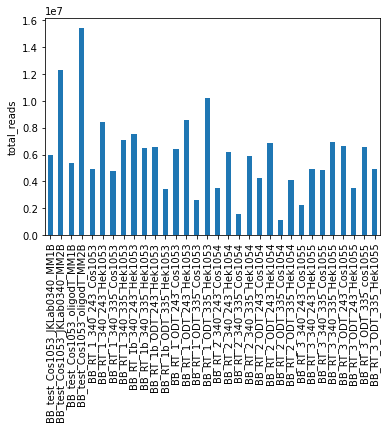

sa_reads


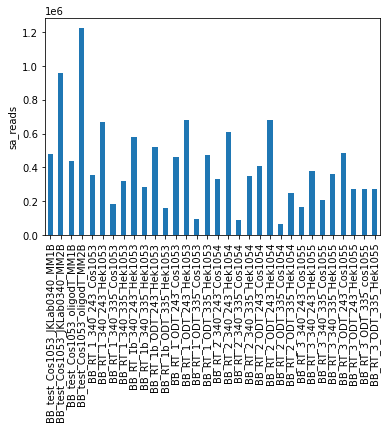

total_clipped


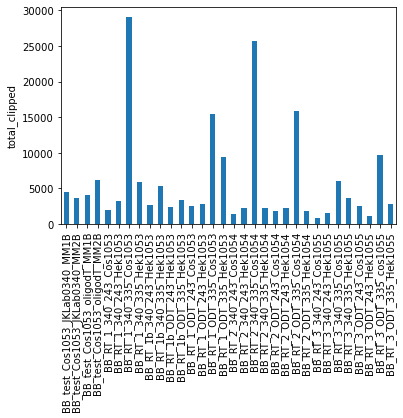

total_bad_starts


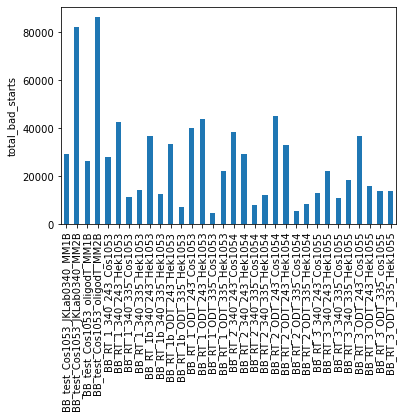

total_bad_ends


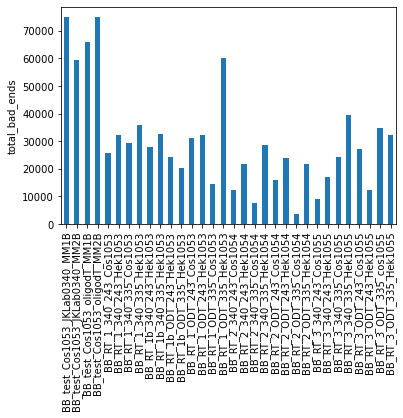

In [76]:
for col in reads_df:
    
    print( col )
    
    reads_df[ col ].plot.bar()
    
    plt.ylabel( col )
    
    plt.show()

sa_reads


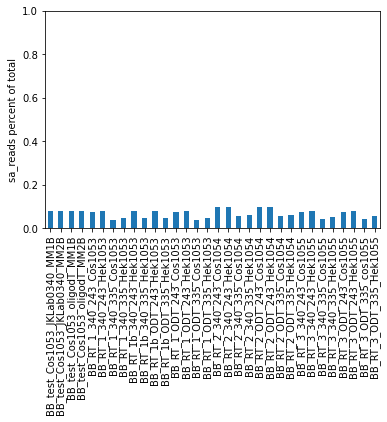

total_clipped


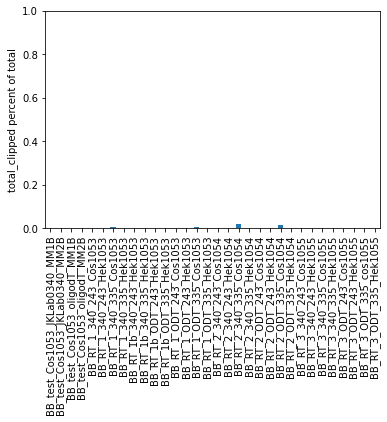

total_bad_starts


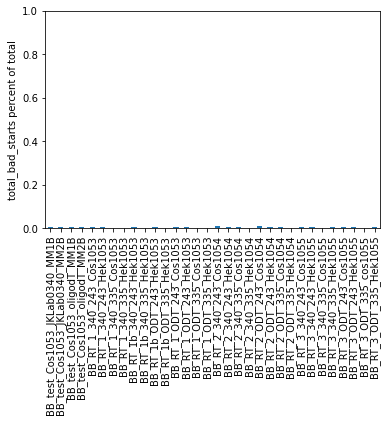

total_bad_ends


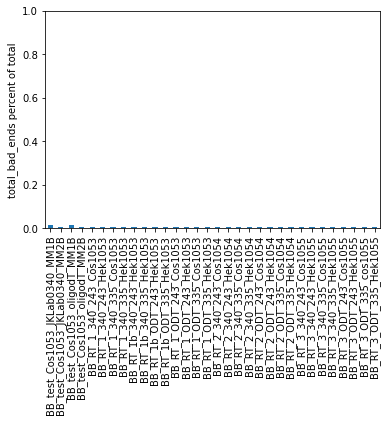

In [77]:
r_df = reads_df.copy()

for col in reads_df:
    
    if col == 'total_reads':
        continue
    
    print( col )
    
    r_df[ 'per_' + col ] = r_df[ col ] / r_df.total_reads
    
    r_df[ 'per_' + col ].plot.bar()
    
    plt.ylim( ( 0, 1 ) )
    
    plt.ylabel( col + ' percent of total' )
    
    plt.show()

In [96]:
total_cols = [ 'total_read_count', 'total_num_bcs', 'total_sum_sa_reads', 'total_num_vars', 'total_passfilt' ]

for col in total_cols:
    
    iso_df_stats_all[ col ] = iso_df_stats_all[ [ lcol for lcol in iso_df_stats_all if col + '_' in lcol ] ].sum( axis = 1 )

In [79]:
len( bam )

32

In [80]:
iso_df_stats_all.shape

(7352, 245)

In [81]:
iso_df_stats_all.query( 'total_passfilt > 0' ).shape

(185, 245)

In [82]:
iso_df_stats_all.query( 'total_passfilt >= 16' ).shape

(14, 245)

In [83]:
( iso_df_stats_all.query( 'total_passfilt == 0' ).total_read_count.sum() / iso_df_stats_all.total_read_count.sum() )*100

1.3267688868382377

In [84]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_read_count.sum() / iso_df_stats_all.total_read_count.sum() )*100

98.40036940714762

In [97]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_sum_sa_reads.sum() / iso_df_stats_all.total_sum_sa_reads.sum() )*100

98.64708285940675

In [107]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_sum_sa_reads.sum() / iso_df_stats_all.query( 'total_passfilt >= 16' ).total_read_count.sum() )*100

6.884644831485577

In [105]:
( iso_df_stats_all.query( 'total_passfilt == 0' ).total_num_bcs.sum() / iso_df_stats_all.total_num_bcs.sum() )*100

2.4665403585511583

In [106]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_num_bcs.sum() / iso_df_stats_all.total_num_bcs.sum() )*100

96.86504387582245

In [116]:
iso_df_stats_all.query( 'total_passfilt >= 24' ).isoform.tolist()

[((1284, 1350),),
 ((1267, 1350),),
 ((1269, 1359),),
 ((1268, 1350),),
 ((1267, 1359),),
 ((1268, 1359),),
 ((1284, 1359),),
 (),
 ((1269, 1350),),
 ((1267, 1347),)]

In [120]:
isogrp_df.loc[ isogrp_df.isoform == ((1235, 1359),) ]

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso4795,"((1235, 1359),)",0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
iso_df_stats_all.loc[ iso_df_stats_all.isoform == ((1236, 1359),) ]

,isonum,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,...,total_read_count_JKP1055,total_num_bcs_JKP1055,total_num_vars_JKP1055,total_sum_sa_reads_JKP1055,total_passfilt_JKP1055,total_read_count,total_num_bcs,total_sum_sa_reads,total_num_vars,total_passfilt
54,iso0054,"((1236, 1359),)",2220,7515,3745,8959,2833,3111,391,358,...,13212,898.0,518.0,1122.0,8,68221,2903.0,6497.0,1893.0,19


In [100]:
iso_df_stats_all.to_csv( bdout + 'wt1_ex9_isoforms_2022-0607.txt',
                         sep = '\t',
                         index = False )

In [101]:
reads_df.to_csv( bdout + 'wt1_ex9_read_cnts_2022-0607.txt',
                         sep = '\t',
                         index = False )